# Visualize Networkss

In [1]:
# Mathematical and Data Managment
import numpy as np
import pandas as pd
import scipy.sparse as sp

# Graph Managment
import graph_tool.all as gt
import networkx as nx
from utils.Functions import *
from utils.Segregation import *

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from fa2.forceatlas2 import ForceAtlas2

# Miscellaneous
from glob import glob
from tqdm import tqdm
import random
import time
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from datetime import datetime, timedelta
import concurrent.futures
from functools import partial

random.seed(2)
np.random.seed(2) 
# Create ForceAtlas2 object with desired parameters
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)

### Testing the package

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:07<00:00, 635.52it/s]


BarnesHut Approximation  took  4.34  seconds
Repulsion forces  took  2.75  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.10  seconds
AdjustSpeedAndApplyForces step  took  0.05  seconds


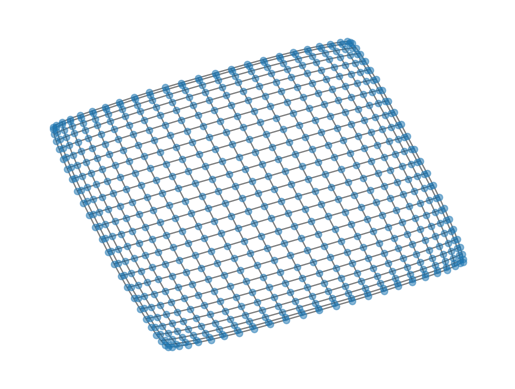

In [3]:
G = nx.grid_2d_graph(25, 25)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=5000)
nx.draw_networkx(G, positions, node_size=20, with_labels=False, alpha=0.5)
plt.axis('off')
plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:02<00:00, 910.66it/s] 


BarnesHut Approximation  took  0.96  seconds
Repulsion forces  took  0.78  seconds
Gravitational forces  took  0.01  seconds
Attraction forces  took  0.28  seconds
AdjustSpeedAndApplyForces step  took  0.01  seconds


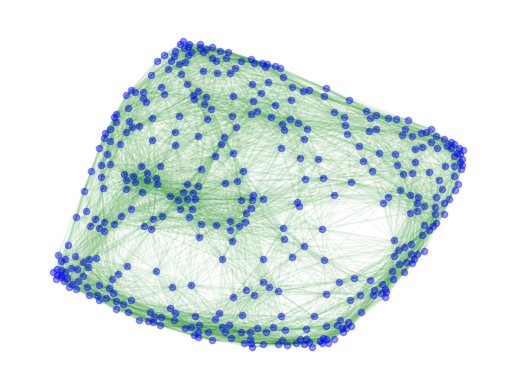

In [3]:
G = nx.random_geometric_graph(400, 0.2, seed=2)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
nx.draw_networkx_nodes(G, positions, node_size=20, node_color="blue", alpha=0.4)
nx.draw_networkx_edges(G, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()

100%|██████████| 10000/10000 [00:00<00:00, 212576.48it/s]

BarnesHut Approximation  took  0.01  seconds
Repulsion forces  took  0.01  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.00  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


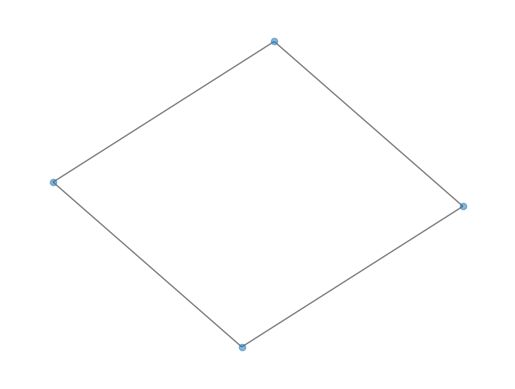

In [4]:
# run forceatlas2
G = np.array([[0, 1, 0, 1], [1, 0, 1, 0], [0, 1, 0, 1], [1, 0, 1, 0]]) # simple 2x2 grid graph
positions = forceatlas2.forceatlas2(G, pos=None, iterations=10000)

# To plot the graph
networkx_graph = nx.from_numpy_array(G)
nx.draw_networkx(networkx_graph, positions, node_size=20, with_labels=False, alpha=0.5)
plt.axis('off')
plt.show()

100%|██████████| 2000/2000 [00:00<00:00, 7420.54it/s]


BarnesHut Approximation  took  0.09  seconds
Repulsion forces  took  0.11  seconds
Gravitational forces  took  0.00  seconds
Attraction forces  took  0.02  seconds
AdjustSpeedAndApplyForces step  took  0.00  seconds


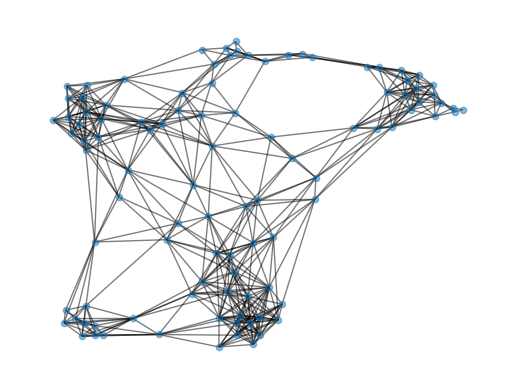

In [6]:
import igraph

# Construct an iGraph
G = nx.random_geometric_graph(100, 0.2)
iG = igraph.Graph.TupleList(G.edges(), directed=False) # converting to iGraph
iG.es['weight'] = np.random.randint(low=1, high=10, size=len(G.edges())) # set random edge weights

# run forceatlas2 on iGraph
layout = forceatlas2.forceatlas2_igraph_layout(iG, pos=None, iterations=2000, weight_attr='weight')

# plot iGraph (using Networkx or you can use iGraph plot func too)
nxG = nx.Graph(iG.get_edgelist())
positions = layout.coords
nx.draw_networkx(nxG, positions, node_size=20, with_labels=False, alpha=0.5)
plt.axis('off')
plt.show()

In [3]:
files = glob('/mnt/disk2/Data/3_Day_Graphs/Graphs/*.graphml')
edges = {file: gt.load_graph(file).num_edges() for file in files}
test_file, edges = max(edges.items(), key=lambda x: x[1])
print(f"Archivo: {test_file}, Enlaces: {edges}")

Archivo: /mnt/disk2/Data/3_Day_Graphs/Graphs/starting_2021-05-03.graphml, Enlaces: 720093


In [4]:
# Load Grap
g = gt.load_graph(test_file)
g_undir = g.copy()

g_undir.set_directed(False)
g_undir_nx = to_networkx(g_undir)
g_nx = to_networkx(g)
del g_undir

In [5]:
print('Layout Grafo Completo:', g_nx)
layout_g_nx = forceatlas2.forceatlas2_networkx_layout(g_undir_nx, pos=None, iterations=500)
del g_undir_nx

Layout Grafo Completo: DiGraph with 36964 nodes and 720093 edges


100%|██████████| 500/500 [13:59<00:00,  1.68s/it]

BarnesHut Approximation  took  298.88  seconds
Repulsion forces  took  528.48  seconds
Gravitational forces  took  0.18  seconds
Attraction forces  took  8.43  seconds
AdjustSpeedAndApplyForces step  took  0.29  seconds


# Force Atlas 2 using Networkx Package

## All the graph

As graph isn't looking good, we are going to draw all the graphs in the middle

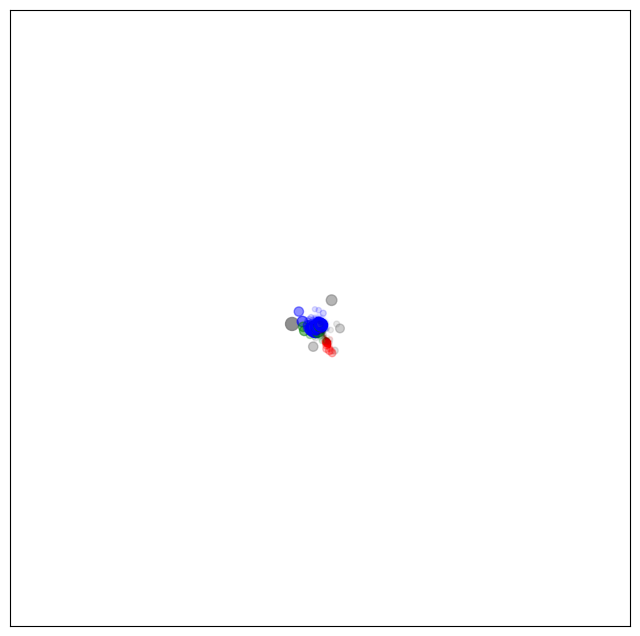

In [6]:
# Color
color_map_dict = {
    'No Retweets': 'gray',
    'Izquierda': 'blue',
    'Derecha': 'red',
    'Centro': 'green'
}
color_map_node = [color_map_dict[g_nx.nodes[node]['Political Label']] for node in g_nx]
color_edge_map = [color_map_dict[g_nx.nodes(data=True)[edge[1]]['Political Label']] for edge in list(g_nx.edges(data=True))]

# Alpha
degrees = dict(g_nx.degree())
max_degree = max(degrees.values())
alpha_values = [(degree / max_degree) for degree in degrees.values()]

# Size
node_degrees = [g_nx.degree(node) * 100 for node in g_nx.nodes()]
def normalize(x, max, min):
    return 100 * ((x - min)/(max - min))
max_deg = max(node_degrees)
min_deg = min(node_degrees)
node_size = list(map(lambda x: normalize(x, max_deg, min_deg), node_degrees))

fig, ax = plt.subplots(figsize = (8,8))

nx.draw_networkx_nodes(g_nx, layout_g_nx, node_color = color_map_node, node_size = node_size, ax = ax, alpha = alpha_values)

plt.show()

Text(0.5, 0, 'Distancia euclideana')

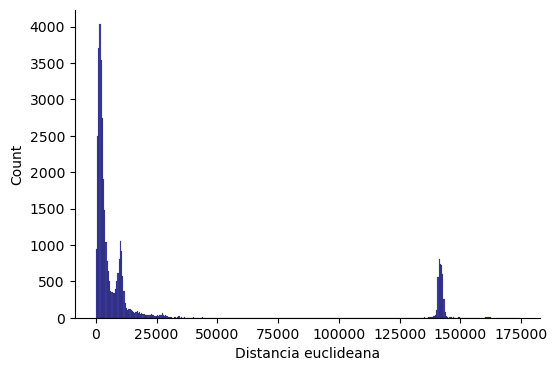

In [7]:
# Vamos a calcular el centroide de toda la red. Vamos a utilizar la mediana
x = [layout_g_nx[i][0] for i in layout_g_nx.keys()]
y = [layout_g_nx[i][1] for i in layout_g_nx.keys()]

centroide_x = np.median(x)
centroide_y = np.median(y)

# Ahora vamos a construir círculos centrados en el centroide con diferentes radios. Con esto en mente 
# queremos definir cual es la proporción de nodos dentro y fuera del circulo  

# Para construir el circulo ideal vamos a revisar las distancias euclideana (eficientemente) de todos los puntos al centroide
resta = np.array(list(zip(x, y))) - np.array((centroide_x, centroide_y))
resta_cuadrado = resta**2
suma_cuadrados = np.sum(resta_cuadrado, axis = 1)
distancia_euclideana = np.sqrt(suma_cuadrados)

# Graficamos histograma de distancias
fig, ax = plt.subplots(figsize = (6, 4))
sns.despine()
sns.histplot(x = distancia_euclideana, color = "darkblue", ax = ax)
plt.xlabel("Distancia euclideana")

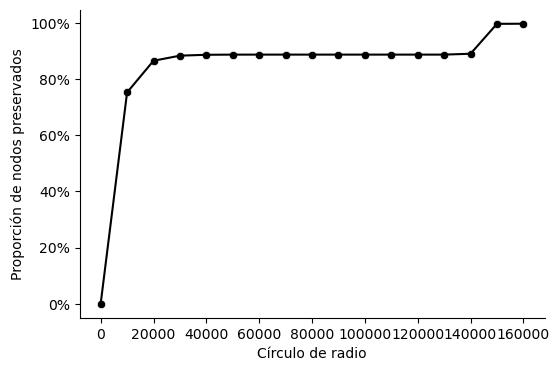

In [8]:
# Creemos una grilla de radios para ver cuantos nodos tenemos en la medida que el circulo crece o decrece
grilla_radios = list(range(0, 160001, 10000)) 
proporcion_nodos = [np.mean(distancia_euclideana < r) for r in grilla_radios]

fig, ax = plt.subplots(figsize = (6, 4))
sns.despine()
sns.lineplot(x = grilla_radios, y = proporcion_nodos, color = "black", ax = ax)
sns.scatterplot(x = grilla_radios, y = proporcion_nodos, color = "black", ax = ax)
plt.xlabel("Círculo de radio")
plt.ylabel("Proporción de nodos preservados")
ax.yaxis.set_major_formatter("{x:0.0%}")

In [9]:
# Usaremos 12,000 como medida de distancia para hacer el zoom
filtro_r_12 = distancia_euclideana < 12000
g_nx_r_12 = g_nx.copy()

# Asegurarse de que la lista booleana tiene la misma longitud que el número de nodos en la red
if len(filtro_r_12) == g_nx_r_12.number_of_nodes():
    # Identificar los nodos a eliminar
    nodos_a_eliminar = [nodo for nodo, mantener in zip(g_nx_r_12.nodes, filtro_r_12) if not mantener]
    porcentaje_eliminacion = len(nodos_a_eliminar)/g_nx_r_12.number_of_nodes()
    print("Vamos a eliminar el {:0.1%} de los nodos".format(porcentaje_eliminacion))
    # Eliminar los nodos
    g_nx_r_12.remove_nodes_from(nodos_a_eliminar)
else:
    print("El filtro y el número de nodos tienen diferente tamaño!")

Vamos a eliminar el 17.4% de los nodos


In [10]:
# Escogemos las posiciones adecuadas, colores y tamaños
pos_r_12 = {key: layout_g_nx[key] for key in g_nx_r_12.nodes}
node_colors_r_12 = np.array(color_map_node)[filtro_r_12]
node_sizes_r_12 = np.array(node_size)[filtro_r_12]*5

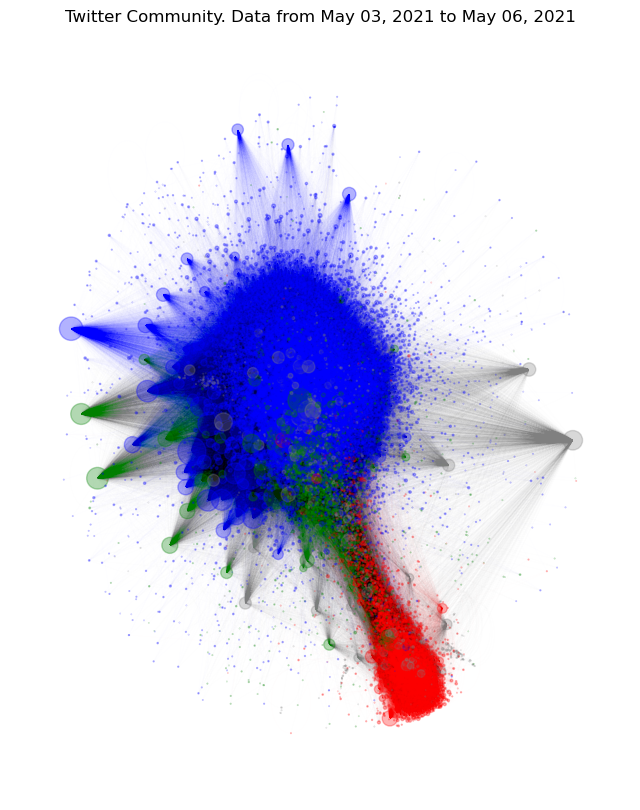

In [11]:
date = g_nx_r_12.graph['Starting Date']
starting_date_obj = datetime.strptime(date, '%Y-%m-%d')
formatted_starting = starting_date_obj.strftime('%B %d, %Y')
ending_date_obj = starting_date_obj + timedelta(days=3)
formatted_ending = ending_date_obj.strftime('%B %d, %Y')

color_edge_map_t = [color_map_dict[g_nx_r_12.nodes(data=True)[edge[1]]['Political Label']] for edge in list(g_nx_r_12.edges(data=True))]

plt.figure(figsize = (8, 10)) 

# Draw nodes with specified size and color
nx.draw_networkx_nodes(g_nx_r_12, pos_r_12, node_color = node_colors_r_12, node_size = node_sizes_r_12, alpha = 0.3);
nx.draw_networkx_edges(g_nx_r_12, pos_r_12, edge_color=color_edge_map_t, alpha = 0.003, arrows=False)
plt.title(f"Twitter Community. Data from {formatted_starting} to {formatted_ending}")

plt.axis('off');

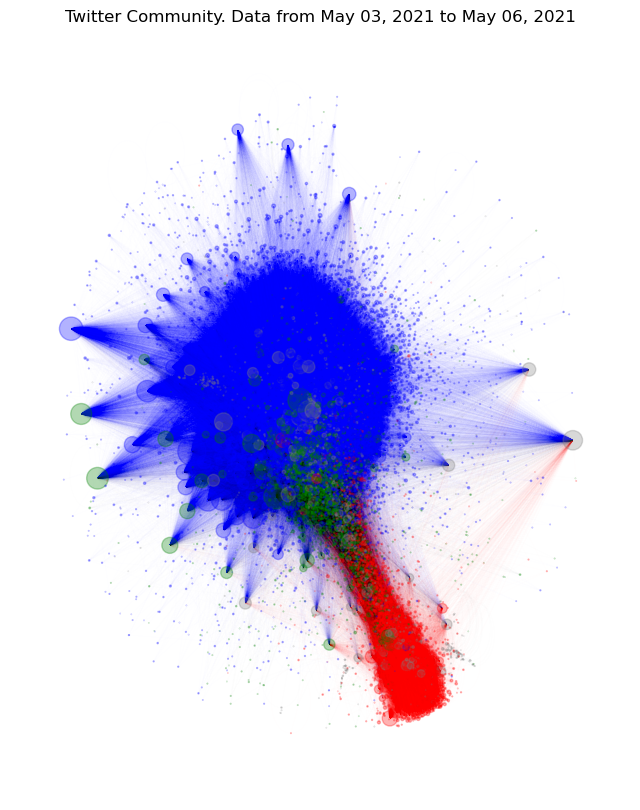

In [12]:
date = g_nx_r_12.graph['Starting Date']
starting_date_obj = datetime.strptime(date, '%Y-%m-%d')
formatted_starting = starting_date_obj.strftime('%B %d, %Y')
ending_date_obj = starting_date_obj + timedelta(days=3)
formatted_ending = ending_date_obj.strftime('%B %d, %Y')
color_edge_map_s = [color_map_dict[g_nx_r_12.nodes(data=True)[edge[0]]['Political Label']] for edge in list(g_nx_r_12.edges(data=True))]
plt.figure(figsize = (8, 10)) 

# Draw nodes with specified size and color
nx.draw_networkx_nodes(g_nx_r_12, pos_r_12, node_color = node_colors_r_12, node_size = node_sizes_r_12, alpha = 0.3);
nx.draw_networkx_edges(g_nx_r_12, pos_r_12, edge_color=color_edge_map_s, alpha = 0.003, arrows=False)

# Draw edges
plt.title(f"Twitter Community. Data from {formatted_starting} to {formatted_ending}")

plt.axis('off');

## ¡Beware! Script ahead

script for loading visualizations. Here, We use the denser Graph to compute the layout using ForceAtlas2 package. This Layout is applied to all the other Graphs

```Results/3_Day_graphs_viz/just_nodes_own_layout```

In [ ]:
def same_layout(file, layout_g_nx):
    g = gt.load_graph(file)
    g_nx = to_networkx(g)
    
    # CREATE AESTHETICS ======================================================
    
    # Color
    color_map_dict = {
        'No Retweets': 'gray',
        'Izquierda': 'blue',
        'Derecha': 'red',
        'Centro': 'green'
    }
    color_map_node = [color_map_dict[g_nx.nodes[node]['Political Label']] for node in g_nx]

    # Size
    node_degrees = [g_nx.degree(node) * 100 for node in g_nx.nodes()]
    def normalize(x, max, min):
        return 100 * ((x - min)/(max - min))
    max_deg = max(node_degrees)
    min_deg = min(node_degrees)
    node_size = list(map(lambda x: normalize(x, max_deg, min_deg), node_degrees))
    
    # CIRCLE FILTER ================================================================================
    
    # Vamos a calcular el centroide de toda la red. Vamos a utilizar la mediana
    x = [layout_g_nx[i][0] for i in layout_g_nx.keys()]
    y = [layout_g_nx[i][1] for i in layout_g_nx.keys()]

    centroide_x = np.median(x)
    centroide_y = np.median(y)

    # Ahora vamos a construir círculos centrados en el centroide con diferentes radios. Con esto en mente 
    # queremos definir cual es la proporción de nodos dentro y fuera del circulo  

    # Para construir el circulo ideal vamos a revisar las distancias euclideana (eficientemente) de todos los puntos al centroide
    resta = np.array(list(zip(x, y))) - np.array((centroide_x, centroide_y))
    resta_cuadrado = resta**2
    suma_cuadrados = np.sum(resta_cuadrado, axis = 1)
    distancia_euclideana = np.sqrt(suma_cuadrados)
    
    # FILTER TO IMPORTANT NODES ===========================================================================

    filtro_r_12 = distancia_euclideana < 12000
    g_nx_r_12 = g_nx.copy()

    # Asegurarse de que la lista booleana tiene la misma longitud que el número de nodos en la red
    if len(filtro_r_12) == g_nx_r_12.number_of_nodes():
        # Identificar los nodos a eliminar
        nodos_a_eliminar = [nodo for nodo, mantener in zip(g_nx_r_12.nodes, filtro_r_12) if not mantener]
        porcentaje_eliminacion = len(nodos_a_eliminar)/g_nx_r_12.number_of_nodes()
        print("Vamos a eliminar el {:0.1%} de los nodos".format(porcentaje_eliminacion))
        # Eliminar los nodos
        g_nx_r_12.remove_nodes_from(nodos_a_eliminar)
    else:
        print("El filtro y el número de nodos tienen diferente tamaño!")

    # Escogemos las posiciones adecuadas, colores y tamaños
    pos_r_12 = {key: layout_g_nx[key] for key in g_nx_r_12.nodes}
    node_colors_r_12 = np.array(color_map_node)[filtro_r_12]
    node_sizes_r_12 = np.array(node_size)[filtro_r_12]*5
    
    color_edge_map_s = [color_map_dict[g_nx_r_12.nodes(data=True)[edge[0]]['Political Label']] for edge in list(g_nx_r_12.edges(data=True))]
    color_edge_map_t = [color_map_dict[g_nx_r_12.nodes(data=True)[edge[1]]['Political Label']] for edge in list(g_nx_r_12.edges(data=True))]
    
    date = g_nx_r_12.graph['Starting Date']
    starting_date_obj = datetime.strptime(date, '%Y-%m-%d')
    formatted_starting = starting_date_obj.strftime('%B %d, %Y')
    ending_date_obj = starting_date_obj + timedelta(days=3)
    formatted_ending = ending_date_obj.strftime('%B %d, %Y')
    
    # GRAAAAAAPH =====================================================================
    
    # Just nodes
    plt.figure(figsize = (8, 10)) 
    nx.draw_networkx_nodes(g_nx_r_12, pos_r_12, node_color = node_colors_r_12, node_size = node_sizes_r_12, alpha = 0.3);
    plt.title(f"Twitter Community. Data from {formatted_starting} to {formatted_ending}")
    plt.axis('off');
    plt.savefig(f"../Results/3_Day_graphs_Viz/just_nodes_same_layout/viz_graph_starting_{date}")
    
    # Coloring Edges based on Source Node
    plt.figure(figsize = (8, 10)) 
    nx.draw_networkx_nodes(g_nx_r_12, pos_r_12, node_color = node_colors_r_12, node_size = node_sizes_r_12, alpha = 0.3);
    nx.draw_networkx_edges(g_nx_r_12, pos_r_12, edge_color=color_edge_map_s, alpha = 0.003, arrows=False)
    plt.title(f"Twitter Community. Data from {formatted_starting} to {formatted_ending}")
    plt.axis('off');
    plt.savefig(f"../Results/3_Day_graphs_Viz/nodes_source_edges_same_layout/viz_graph_starting_{date}")
    
    # Coloring Edges based on Target Node
    plt.figure(figsize = (8, 10)) 
    nx.draw_networkx_nodes(g_nx_r_12, pos_r_12, node_color = node_colors_r_12, node_size = node_sizes_r_12, alpha = 0.3);
    nx.draw_networkx_edges(g_nx_r_12, pos_r_12, edge_color=color_edge_map_t, alpha = 0.003, arrows=False)
    plt.title(f"Twitter Community. Data from {formatted_starting} to {formatted_ending}")
    plt.axis('off');
    plt.savefig(f"../Results/3_Day_graphs_Viz/nodes_target_edges_same_layout/viz_graph_starting_{date}")
    print('-'*50)
    return None

def main():
    files = glob('/mnt/disk2/Data/3_Day_Graphs/Graphs/*.graphml')
    edges = {file: gt.load_graph(file).num_edges() for file in files}
    test_file, edges = max(edges.items(), key=lambda x: x[1])
    
    # Load Graph
    g = gt.load_graph(test_file)
    g_undir = g.copy()
    g_undir.set_directed(False)
    g_undir_nx = to_networkx(g_undir)
    del g_undir
    
    # Get Layout, add it to the function
    layout_g_nx = forceatlas2.forceatlas2_networkx_layout(g_undir_nx, pos=None, iterations=500)
    same_layout_included = partial(same_layout, layout_g_nx=layout_g_nx)
    del g_undir_nx
    
    with concurrent.futures.ProcessPoolExecutor() as executor:
        executor.map(same_layout_included, files)

if __name__ == '__main__':
    main()

## ¡Beware! Script ahead

script for loading just the nodes computing a an individual algorithym results at:

```Results/3_Day_graphs_viz/just_nodes_own_layout```

In [17]:
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=False)

def own_layout(file, initial_pos):  
    
    # LOAD GRAPH ============================================================= 
    # Load Grap
    g = gt.load_graph(file)
    g_undir = g.copy()

    g_undir.set_directed(False)
    g_undir_nx = to_networkx(g_undir)
    g_nx = to_networkx(g)
    del g_undir
    
    # CRTEATE LAYOUT ==========================================================                                         
    layout_g_nx = forceatlas2.forceatlas2_networkx_layout(g_undir_nx, pos=initial_pos, iterations=500)
    del g_undir_nx
    
    # CREATE AESTHETICS ======================================================
    
    # Color
    color_map_dict = {
        'No Retweets': 'gray',
        'Izquierda': 'blue',
        'Derecha': 'red',
        'Centro': 'green'
    }
    color_map_node = [color_map_dict[g_nx.nodes[node]['Political Label']] for node in g_nx]

    # Size
    node_degrees = [g_nx.degree(node) * 100 for node in g_nx.nodes()]
    def normalize(x, max, min):
        return 100 * ((x - min)/(max - min))
    max_deg = max(node_degrees)
    min_deg = min(node_degrees)
    node_size = list(map(lambda x: normalize(x, max_deg, min_deg), node_degrees))
    
    # CIRCLE FILTER ================================================================================
    
    # Vamos a calcular el centroide de toda la red. Vamos a utilizar la mediana
    x = [layout_g_nx[i][0] for i in layout_g_nx.keys()]
    y = [layout_g_nx[i][1] for i in layout_g_nx.keys()]

    centroide_x = np.median(x)
    centroide_y = np.median(y)

    # Ahora vamos a construir círculos centrados en el centroide con diferentes radios. Con esto en mente 
    # queremos definir cual es la proporción de nodos dentro y fuera del circulo  

    # Para construir el circulo ideal vamos a revisar las distancias euclideana (eficientemente) de todos los puntos al centroide
    resta = np.array(list(zip(x, y))) - np.array((centroide_x, centroide_y))
    resta_cuadrado = resta**2
    suma_cuadrados = np.sum(resta_cuadrado, axis = 1)
    distancia_euclideana = np.sqrt(suma_cuadrados)
    
    # FILTER TO IMPORTANT NODES ===========================================================================

    filtro_r_12 = distancia_euclideana < 12000
    g_nx_r_12 = g_nx.copy()

    # Asegurarse de que la lista booleana tiene la misma longitud que el número de nodos en la red
    if len(filtro_r_12) == g_nx_r_12.number_of_nodes():
        # Identificar los nodos a eliminar
        nodos_a_eliminar = [nodo for nodo, mantener in zip(g_nx_r_12.nodes, filtro_r_12) if not mantener]
        porcentaje_eliminacion = len(nodos_a_eliminar)/g_nx_r_12.number_of_nodes()
        print("Vamos a eliminar el {:0.1%} de los nodos".format(porcentaje_eliminacion))
        # Eliminar los nodos
        g_nx_r_12.remove_nodes_from(nodos_a_eliminar)
    else:
        print("El filtro y el número de nodos tienen diferente tamaño!")

    # Escogemos las posiciones adecuadas, colores y tamaños
    pos_r_12 = {key: layout_g_nx[key] for key in g_nx_r_12.nodes}
    node_colors_r_12 = np.array(color_map_node)[filtro_r_12]
    node_sizes_r_12 = np.array(node_size)[filtro_r_12]*5
    
    color_edge_map_s = [color_map_dict[g_nx_r_12.nodes(data=True)[edge[0]]['Political Label']] for edge in list(g_nx_r_12.edges(data=True))]
    color_edge_map_t = [color_map_dict[g_nx_r_12.nodes(data=True)[edge[1]]['Political Label']] for edge in list(g_nx_r_12.edges(data=True))]
    
    date = g_nx_r_12.graph['Starting Date']
    starting_date_obj = datetime.strptime(date, '%Y-%m-%d')
    formatted_starting = starting_date_obj.strftime('%B %d, %Y')
    ending_date_obj = starting_date_obj + timedelta(days=3)
    formatted_ending = ending_date_obj.strftime('%B %d, %Y')
    
    # GRAAAAAAPH =====================================================================  
    
    # Just nodes
    plt.figure(figsize = (8, 10)) 
    nx.draw_networkx_nodes(g_nx_r_12, pos_r_12, node_color = node_colors_r_12, node_size = node_sizes_r_12, alpha = 0.3);
    plt.title(f"Twitter Community. Data from {formatted_starting} to {formatted_ending}")
    plt.axis('off');
    plt.savefig(f"../Results/3_Day_graphs_Viz/just_nodes_own_layout/viz_graph_starting_{date}")
    
    # Coloring Edges based on Source Node
    plt.figure(figsize = (8, 10)) 
    nx.draw_networkx_nodes(g_nx_r_12, pos_r_12, node_color = node_colors_r_12, node_size = node_sizes_r_12, alpha = 0.3);
    nx.draw_networkx_edges(g_nx_r_12, pos_r_12, edge_color=color_edge_map_s, alpha = 0.003, arrows=False)
    plt.title(f"Twitter Community. Data from {formatted_starting} to {formatted_ending}")
    plt.axis('off');
    plt.savefig(f"../Results/3_Day_graphs_Viz/nodes_source_edges_own_layout/viz_graph_starting_{date}")
    
    # Coloring Edges based on Target Node
    plt.figure(figsize = (8, 10)) 
    nx.draw_networkx_nodes(g_nx_r_12, pos_r_12, node_color = node_colors_r_12, node_size = node_sizes_r_12, alpha = 0.3);
    nx.draw_networkx_edges(g_nx_r_12, pos_r_12, edge_color=color_edge_map_t, alpha = 0.003, arrows=False)
    plt.title(f"Twitter Community. Data from {formatted_starting} to {formatted_ending}")
    plt.axis('off');
    plt.savefig(f"../Results/3_Day_graphs_Viz/nodes_target_edges_own_layout/viz_graph_starting_{date}")

def main():
    files = glob('/mnt/disk2/Data/3_Day_Graphs/Graphs/*.graphml')
    # Get Layout, add it to the function
    initial_pos = {node: (random.random(), random.random()) for node in range(36964)}
    own_layout_included = partial(own_layout, initial_pos=initial_pos)
    
    with concurrent.futures.ProcessPoolExecutor() as executor:
        executor.map(own_layout_included, files)

if __name__ == '__main__':
    main()

print('***************************Terminado******************************')

Vamos a eliminar el 33.1% de los nodos
Vamos a eliminar el 34.1% de los nodos
Vamos a eliminar el 33.5% de los nodos
Vamos a eliminar el 31.5% de los nodos
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
Vamos a eliminar el 30.7% de los nodos
Vamos a eliminar el 29.5% de los nodos
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
Vamos a eliminar el 24.9% de los nodos
Vamos a eliminar el 24.7% de los nodos
Vamos a eliminar el 26.5% de los nodos
Vamos a eliminar el 24.0% de los nodos
Vamos a eliminar el 24.5% de los nodos
Vamos a eliminar el 23.1% de los nodos
Vamos a eliminar el 23.6% de los nodos
--------------------------------------------------
--------------------------------------------------
--------------------------------------------------
----------------------------------

In [ ]:
def gephi_layout(file, layout_gephi):
    g = gt.load_graph(file)
    g_nx = to_networkx(g)
    
    # CREATE AESTHETICS ======================================================
    
    # Color
    color_map_dict = {
        'No Retweets': 'gray',
        'Izquierda': 'blue',
        'Derecha': 'red',
        'Centro': 'green'
    }
    color_map_node = [color_map_dict[g_nx.nodes[node]['Political Label']] for node in g_nx]

    # Size
    node_degrees = [g_nx.degree(node) * 100 for node in g_nx.nodes()]
    def normalize(x, max, min):
        return 100 * ((x - min)/(max - min))
    max_deg = max(node_degrees)
    min_deg = min(node_degrees)
    node_size = list(map(lambda x: normalize(x, max_deg, min_deg), node_degrees))
    
    # CIRCLE FILTER ================================================================================
    
    # Vamos a calcular el centroide de toda la red. Vamos a utilizar la mediana
    x = [layout_gephi[i][0] for i in layout_gephi.keys()]
    y = [layout_gephi[i][1] for i in layout_gephi.keys()]

    centroide_x = np.median(x)
    centroide_y = np.median(y)

    # Ahora vamos a construir círculos centrados en el centroide con diferentes radios. Con esto en mente 
    # queremos definir cual es la proporción de nodos dentro y fuera del circulo  

    # Para construir el circulo ideal vamos a revisar las distancias euclideana (eficientemente) de todos los puntos al centroide
    resta = np.array(list(zip(x, y))) - np.array((centroide_x, centroide_y))
    resta_cuadrado = resta**2
    suma_cuadrados = np.sum(resta_cuadrado, axis = 1)
    distancia_euclideana = np.sqrt(suma_cuadrados)
    
    # FILTER TO IMPORTANT NODES ===========================================================================

    filtro_r_10 = distancia_euclideana < 10000
    g_nx_r_10 = g_nx.copy()

    # Asegurarse de que la lista booleana tiene la misma longitud que el número de nodos en la red
    if len(filtro_r_10) == g_nx_r_10.number_of_nodes():
        # Identificar los nodos a eliminar
        nodos_a_eliminar = [nodo for nodo, mantener in zip(g_nx_r_10.nodes, filtro_r_10) if not mantener]
        porcentaje_eliminacion = len(nodos_a_eliminar)/g_nx_r_10.number_of_nodes()
        print("Vamos a eliminar el {:0.1%} de los nodos".format(porcentaje_eliminacion))
        # Eliminar los nodos
        g_nx_r_10.remove_nodes_from(nodos_a_eliminar)
    else:
        print("El filtro y el número de nodos tienen diferente tamaño!")

    # Escogemos las posiciones adecuadas, colores y tamaños
    pos_r_10 = {key: layout_gephi[key] for key in g_nx_r_10.nodes}
    node_colors_r_10 = np.array(color_map_node)[filtro_r_10]
    node_sizes_r_10 = np.array(node_size)[filtro_r_10]*5
    
    color_edge_map_s = [color_map_dict[g_nx_r_10.nodes(data=True)[edge[0]]['Political Label']] for edge in list(g_nx_r_10.edges(data=True))]
    color_edge_map_t = [color_map_dict[g_nx_r_10.nodes(data=True)[edge[1]]['Political Label']] for edge in list(g_nx_r_10.edges(data=True))]
    
    date = g_nx_r_10.graph['Starting Date']
    starting_date_obj = datetime.strptime(date, '%Y-%m-%d')
    formatted_starting = starting_date_obj.strftime('%B %d, %Y')
    ending_date_obj = starting_date_obj + timedelta(days=3)
    formatted_ending = ending_date_obj.strftime('%B %d, %Y')
    
    # GRAAAAAAPH =====================================================================
    
    # Just nodes
    plt.figure(figsize = (8, 10)) 
    nx.draw_networkx_nodes(g_nx_r_10, pos_r_10, node_color = node_colors_r_10, node_size = node_sizes_r_10, alpha = 0.3);
    plt.title(f"Twitter Community. Data from {formatted_starting} to {formatted_ending}")
    plt.axis('off');
    plt.savefig(f"../Results/3_Day_graphs_Viz/just_nodes_gephi_layout/viz_graph_starting_{date}")
    
    # Coloring Edges based on Source Node
    plt.figure(figsize = (8, 10)) 
    nx.draw_networkx_nodes(g_nx_r_10, pos_r_10, node_color = node_colors_r_10, node_size = node_sizes_r_10, alpha = 0.3);
    nx.draw_networkx_edges(g_nx_r_10, pos_r_10, edge_color=color_edge_map_s, alpha = 0.003, arrows=False)
    plt.title(f"Twitter Community. Data from {formatted_starting} to {formatted_ending}")
    plt.axis('off');
    plt.savefig(f"../Results/3_Day_graphs_Viz/nodes_source_edges_gephi_layout/viz_graph_starting_{date}")
    
    # Coloring Edges based on Target Node
    plt.figure(figsize = (8, 10)) 
    nx.draw_networkx_nodes(g_nx_r_10, pos_r_10, node_color = node_colors_r_10, node_size = node_sizes_r_10, alpha = 0.3);
    nx.draw_networkx_edges(g_nx_r_10, pos_r_10, edge_color=color_edge_map_t, alpha = 0.003, arrows=False)
    plt.title(f"Twitter Community. Data from {formatted_starting} to {formatted_ending}")
    plt.axis('off');
    plt.savefig(f"../Results/3_Day_graphs_Viz/nodes_target_edges_gephi_layout/viz_graph_starting_{date}")
    print('-'*50)
    return None

def main():
    files = glob('/mnt/disk2/Data/3_Day_Graphs/*.graphml')
    gephi_positions = pd.read_csv('/mnt/disk2/Data/3_Day_Graphs/positions_gephi.csv', delimiter=';')
    gephi_positions['X'] = gephi_positions['X'].apply(lambda x: x.replace(',','.'))
    gephi_positions['Y'] = gephi_positions['Y'].apply(lambda x: x.replace(',','.'))
    gephi_positions.head()
    
    # Get Layout, add it to the function 
    layout_gephi = {int(row.Id[1:]) : (float(row.X), float(row.Y)) for row in gephi_positions.itertuples(index=False)}
    gephi_layout_included = partial(gephi_layout, layout_gephi=layout_gephi)
    
    with concurrent.futures.ProcessPoolExecutor() as executor:
        executor.map(gephi_layout_included, files)

if __name__ == '__main__':
    main()